# Hyperparameter Optimization: ``num_simulations`

- Assumption: The more simulations i use the better my model will approximate unseen data. 
- BUT: The more simulations i use the more computation is needed to simulate data and train the model.
- Question: How many simulations are needed to have good performance and still acceptable computational load?

In [1]:
# add the 'src' as root folder, to find other modules in the project
import sys
sys.path.append("../../")

In [2]:
# external imports
import torch
import os

from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
from sbi.utils import posterior_nn
from torch.distributions import Normal, Independent, Uniform
# local imports
from utilities.simulator.swing_equation import Swing
from utilities.analysis.distribution_analysis import DistributionAnalysis

ImportError: cannot import name 'TruncatedNormal' from 'torch.distributions' (/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/.venv/lib64/python3.9/site-packages/torch/distributions/__init__.py)

In [3]:
# define devices for simulation and training
sim_device = torch.device('cpu')
est_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# define output directory, for results
output_path = "../../results/hyperparameter_choices/num_simulations"
output_path_figure = output_path + "/figure"
output_path_table = output_path + "/table"

# define default sampling size
number_samples = 10**5

In [5]:
# Time and stepsize
T = 900
dt = 1

# Simulation process parameters
simulation_params = {
    "num_simulations": [10**2, 10**3, 10**4, 10**5],
    "num_workers": os.cpu_count(),
    "simulation_batch_size": 50
}

# Density estimator parameters
training_params = {
    "model": 'maf',
    "hidden_features": 70,
    "num_transforms": 15,
    "num_bins": 25,
    "num_rounds": 5
}

# Add nonlinearity to the simulator
c1 = lambda x, y: -x*y-x*y**3
c2 = lambda x, y: -x*y-x*y**3

# Model for data simulation
simulator_model = Swing(f=c1, g=c2, dt=dt, T=T)

# True parameters for the swing equation
true_parameters = {
    'c_1': 0.01,
    'c_2': 0.0001,
    'P_0': 0.001,
    'P_1': 0.00001,
    '\epsilon': 0.001
}

# true parameters
true_parameters_base = torch.tensor(list(true_parameters.values()))
std_deviations_base = torch.tensor([0.001, 0.00001, 0.0001, 0.000001, 0.0001,])

mean_noise_scale = 1.0 
mean_noise_constant = 0 
std_noise_scale = 1.0 
std_noise_constant = 0 

# proposal: Uniform distributions around the true parameter value, negative values are not allowed
proposal = Independent(Uniform(low=0, high=true_parameters_base*10), 1)

# prior: Normal distributions around the true parameter value (with or without noise)
prior = Independent(Normal(loc=true_parameters_base*mean_noise_scale + mean_noise_constant, scale=std_deviations_base*std_noise_scale + std_noise_constant), 1)

# observation with true parameters
observation = simulator_model.simulator(true_parameters_base)

In [6]:
# check for compatibility
simulator, proposal = prepare_for_sbi(simulator_model.simulator, proposal)

training_data = []

for num_simulations in simulation_params.get('num_simulations'):
    simulations, parameters = simulate_for_sbi(
        simulator=simulator, 
        proposal=proposal, 
        num_simulations=num_simulations, 
        num_workers=simulation_params.get('num_workers'), 
        simulation_batch_size=simulation_params.get('simulation_batch_size')
    )

    training_data.append((simulations, parameters))

Running 100 simulations in 2 batches.:   0%|          | 0/2 [00:00<?, ?it/s]

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


Running 1000 simulations in 20 batches.:   0%|          | 0/20 [00:00<?, ?it/s]

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/ho

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/ho

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


Running 10000 simulations in 200 batches.:   0%|          | 0/200 [00:00<?, ?it/s]

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/ho

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/ho

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/ho

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/notebooks/hyperparameter_choices/../../utilities/simulator/sde_base.py:52: RuntimeWarning: invalid value encountered in add
  X[:, i+1] = X[:, i] + self._a(X[:, i], t[i], parameters) * self.dt + self._b(X[:, i], t[i], parameters) * dW


Running 100000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

In [7]:
posteriors = []

# once simulations are done, move the data to GPU (if available) for density estimator
for simulations, parameters in training_data:

    simulations.to(est_device)
    parameters.to(est_device)

    # define neural posterior with given parameters for @SNPE
    neural_posterior = posterior_nn(
        model=training_params.get('model'), 
        hidden_features=training_params.get('hidden_features'), 
        num_transforms=training_params.get('num_transforms'), 
        num_bins=training_params.get('num_bins')
    )

    # Set up the inference procedure with the SNPE procedure, and custom neural density estimator
    inference = SNPE(prior=prior, density_estimator=neural_posterior)

    # Train the neural density estimator
    density_estimator = inference.append_simulations(simulations, parameters, data_device=est_device).train()

    # Build the posterior for the given parameters
    posterior = inference.build_posterior(density_estimator).set_default_x(observation)

    posteriors.append(posterior)

posteriors = zip(simulation_params.get('num_simulations'), posteriors)

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/.venv/lib64/python3.9/site-packages/sbi/utils/user_input_checks.py:720: UserWarning: Data x has device 'cpu'.Moving x to the data_device 'cuda'.Training will proceed on device 'cpu'.
  warnings.warn(
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/.venv/lib64/python3.9/site-packages/sbi/utils/user_input_checks.py:728: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda'.Training will proceed on device 'cpu'.
  warnings.warn(



 Training neural network. Epochs trained: 1
 Training neural network. Epochs trained: 2
 Training neural network. Epochs trained: 3
 Training neural network. Epochs trained: 4
 Training neural network. Epochs trained: 5


 Training neural network. Epochs trained: 6
 Training neural network. Epochs trained: 7
 Training neural network. Epochs trained: 8
 Training neural network. Epochs trained: 9
 Training neural network. Epochs trained: 10
 Training neural network. Epochs trained: 11


 Training neural network. Epochs trained: 12
 Training neural network. Epochs trained: 13
 Training neural network. Epochs trained: 14
 Training neural network. Epochs trained: 15
 Training neural network. Epochs trained: 16
 Training neural network. Epochs trained: 17


 Training neural network. Epochs trained: 18
 Training neural network. Epochs trained: 19
 Training neural network. Epochs trained: 20
 Training neural network. Epochs trained: 21
 Training neural network. Epochs trained: 22
 Training neural network. Epochs trained: 23


 Training neural network. Epochs trained: 24
 Training neural network. Epochs trained: 25
 Training neural network. Epochs trained: 26
 Training neural network. Epochs trained: 27
 Training neural network. Epochs trained: 28
 Training neural network. Epochs trained: 29


 Training neural network. Epochs trained: 30
 Training neural network. Epochs trained: 31
 Training neural network. Epochs trained: 32
 Training neural network. Epochs trained: 33
 Training neural network. Epochs trained: 34
 Training neural network. Epochs trained: 35
 Training neural network. Epochs trained: 36


 Training neural network. Epochs trained: 37
 Training neural network. Epochs trained: 38
 Training neural network. Epochs trained: 39
 Training neural network. Epochs trained: 40
 Training neural network. Epochs trained: 41
 Training neural network. Epochs trained: 42


 Training neural network. Epochs trained: 43
 Training neural network. Epochs trained: 44
 Training neural network. Epochs trained: 45
 Training neural network. Epochs trained: 46
 Training neural network. Epochs trained: 47
 Training neural network. Epochs trained: 48
 Training neural network. Epochs trained: 49
 Training neural network. Epochs trained: 50


 Training neural network. Epochs trained: 51
 Training neural network. Epochs trained: 52
 Training neural network. Epochs trained: 53
 Training neural network. Epochs trained: 54
 Training neural network. Epochs trained: 55
 Training neural network. Epochs trained: 56
 Training neural network. Epochs trained: 57
 Training neural network. Epochs trained: 58


 Training neural network. Epochs trained: 59
 Training neural network. Epochs trained: 60
 Neural network successfully converged after 60 epochs.

/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/.venv/lib64/python3.9/site-packages/sbi/utils/user_input_checks.py:720: UserWarning: Data x has device 'cpu'.Moving x to the data_device 'cuda'.Training will proceed on device 'cpu'.
  warnings.warn(
/pfs/data5/home/kit/iai/ik6649/Data-Driven-Bayesian-Parameter-Estimation-with-Neural-Networks/.venv/lib64/python3.9/site-packages/sbi/utils/user_input_checks.py:728: UserWarning: Parameters theta has device 'cpu'. Moving theta to the data_device 'cuda'.Training will proceed on device 'cpu'.
  warnings.warn(



 Training neural network. Epochs trained: 1
 Training neural network. Epochs trained: 2


 Training neural network. Epochs trained: 3
 Training neural network. Epochs trained: 4


 Training neural network. Epochs trained: 5
 Training neural network. Epochs trained: 6


 Training neural network. Epochs trained: 7
 Training neural network. Epochs trained: 8


 Training neural network. Epochs trained: 9
 Training neural network. Epochs trained: 10


 Training neural network. Epochs trained: 11
 Training neural network. Epochs trained: 12


 Training neural network. Epochs trained: 13
 Training neural network. Epochs trained: 14


 Training neural network. Epochs trained: 15
 Training neural network. Epochs trained: 16


 Training neural network. Epochs trained: 17
 Training neural network. Epochs trained: 18


 Training neural network. Epochs trained: 19
 Training neural network. Epochs trained: 20


 Training neural network. Epochs trained: 21
 Training neural network. Epochs trained: 22


 Training neural network. Epochs trained: 23
 Training neural network. Epochs trained: 24


 Training neural network. Epochs trained: 25
 Training neural network. Epochs trained: 26


 Training neural network. Epochs trained: 27
 Training neural network. Epochs trained: 28


 Training neural network. Epochs trained: 29
 Training neural network. Epochs trained: 30


 Training neural network. Epochs trained: 31
 Training neural network. Epochs trained: 32


 Training neural network. Epochs trained: 33
 Training neural network. Epochs trained: 34


 Training neural network. Epochs trained: 35
 Neural network successfully converged after 35 epochs.


 Training neural network. Epochs trained: 1


 Training neural network. Epochs trained: 2


 Training neural network. Epochs trained: 3


 Training neural network. Epochs trained: 4


 Training neural network. Epochs trained: 5


 Training neural network. Epochs trained: 6


 Training neural network. Epochs trained: 7


 Training neural network. Epochs trained: 8


 Training neural network. Epochs trained: 9


 Training neural network. Epochs trained: 10


 Training neural network. Epochs trained: 11


 Training neural network. Epochs trained: 12


 Training neural network. Epochs trained: 13


 Training neural network. Epochs trained: 14


 Training neural network. Epochs trained: 15


 Training neural network. Epochs trained: 16


 Training neural network. Epochs trained: 17


 Training neural network. Epochs trained: 18


 Training neural network. Epochs trained: 19


 Training neural network. Epochs trained: 20


 Training neural network. Epochs trained: 21


 Training neural network. Epochs trained: 22


 Training neural network. Epochs trained: 23


 Training neural network. Epochs trained: 24


 Training neural network. Epochs trained: 25


 Training neural network. Epochs trained: 26


 Training neural network. Epochs trained: 27


 Training neural network. Epochs trained: 28


 Training neural network. Epochs trained: 29


 Training neural network. Epochs trained: 30


 Training neural network. Epochs trained: 31


 Training neural network. Epochs trained: 32


 Training neural network. Epochs trained: 33


 Training neural network. Epochs trained: 34


 Training neural network. Epochs trained: 35


 Training neural network. Epochs trained: 36


 Training neural network. Epochs trained: 37


 Training neural network. Epochs trained: 38
 Neural network successfully converged after 38 epochs.


 Training neural network. Epochs trained: 1


 Training neural network. Epochs trained: 2


 Training neural network. Epochs trained: 3


 Training neural network. Epochs trained: 4


 Training neural network. Epochs trained: 5


 Training neural network. Epochs trained: 6


 Training neural network. Epochs trained: 7


 Training neural network. Epochs trained: 8


 Training neural network. Epochs trained: 9


 Training neural network. Epochs trained: 10


 Training neural network. Epochs trained: 11


 Training neural network. Epochs trained: 12


 Training neural network. Epochs trained: 13


 Training neural network. Epochs trained: 14


 Training neural network. Epochs trained: 15


 Training neural network. Epochs trained: 16


 Training neural network. Epochs trained: 17


 Training neural network. Epochs trained: 18


 Training neural network. Epochs trained: 19


 Training neural network. Epochs trained: 20


 Training neural network. Epochs trained: 21


 Training neural network. Epochs trained: 22


 Training neural network. Epochs trained: 23


 Training neural network. Epochs trained: 24


 Training neural network. Epochs trained: 25


 Training neural network. Epochs trained: 26


 Training neural network. Epochs trained: 27


 Training neural network. Epochs trained: 28


 Training neural network. Epochs trained: 29


 Training neural network. Epochs trained: 30


 Training neural network. Epochs trained: 31


 Training neural network. Epochs trained: 32


 Training neural network. Epochs trained: 33


 Training neural network. Epochs trained: 34


 Training neural network. Epochs trained: 35


 Training neural network. Epochs trained: 36


 Training neural network. Epochs trained: 37


 Training neural network. Epochs trained: 38


 Training neural network. Epochs trained: 39


 Training neural network. Epochs trained: 40


 Training neural network. Epochs trained: 41


 Training neural network. Epochs trained: 42


 Training neural network. Epochs trained: 43


 Training neural network. Epochs trained: 44


 Training neural network. Epochs trained: 45


 Training neural network. Epochs trained: 46
 Neural network successfully converged after 46 epochs.

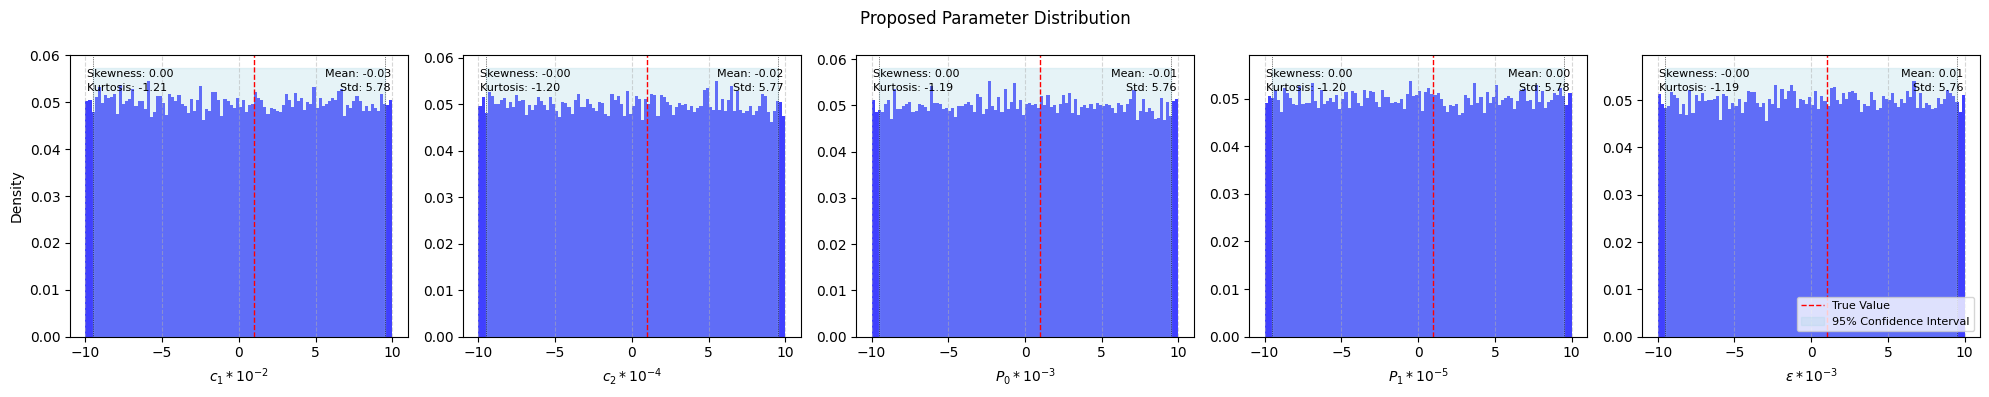

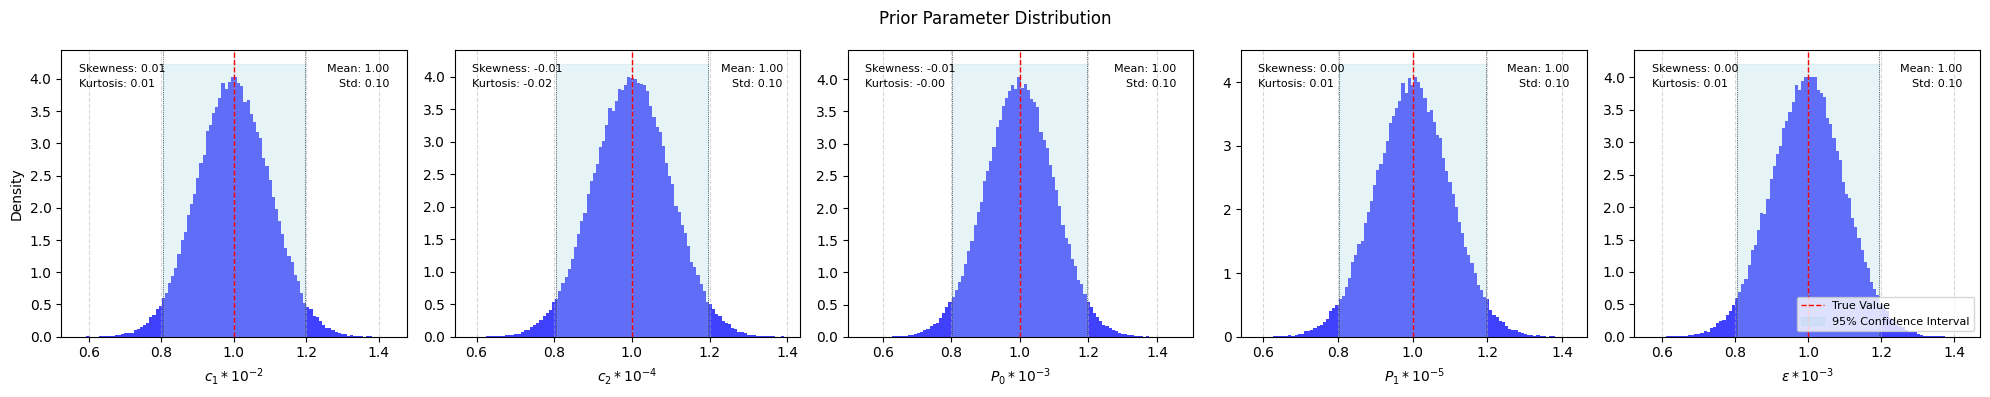

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

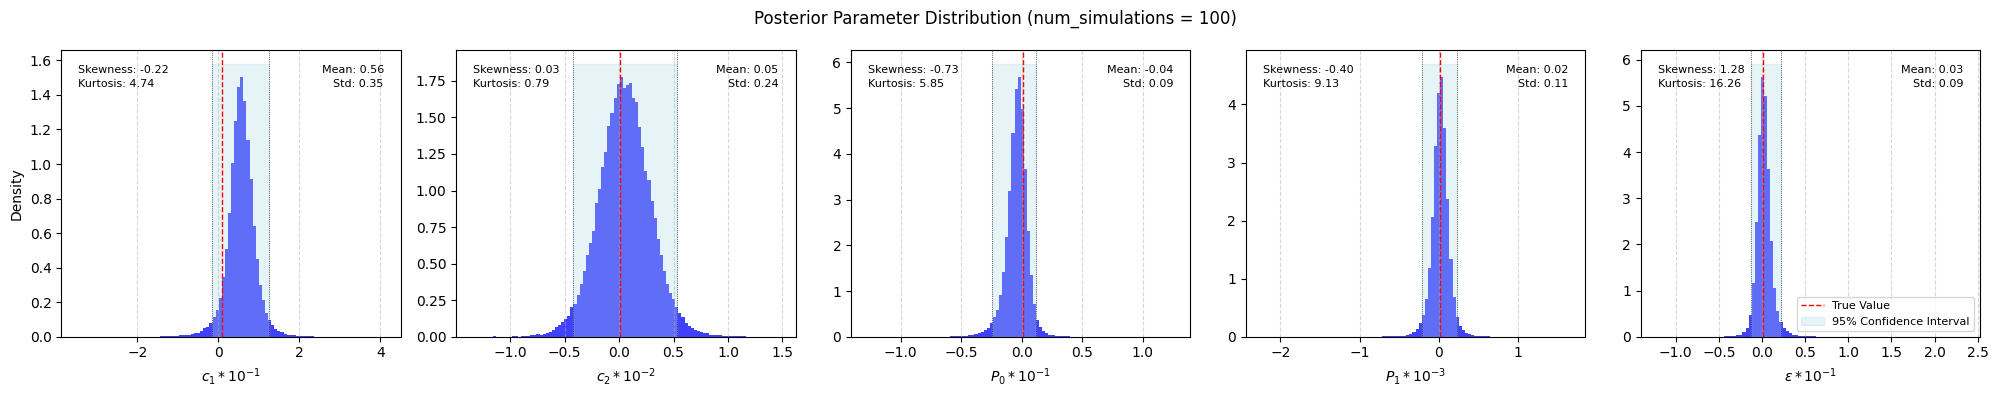

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

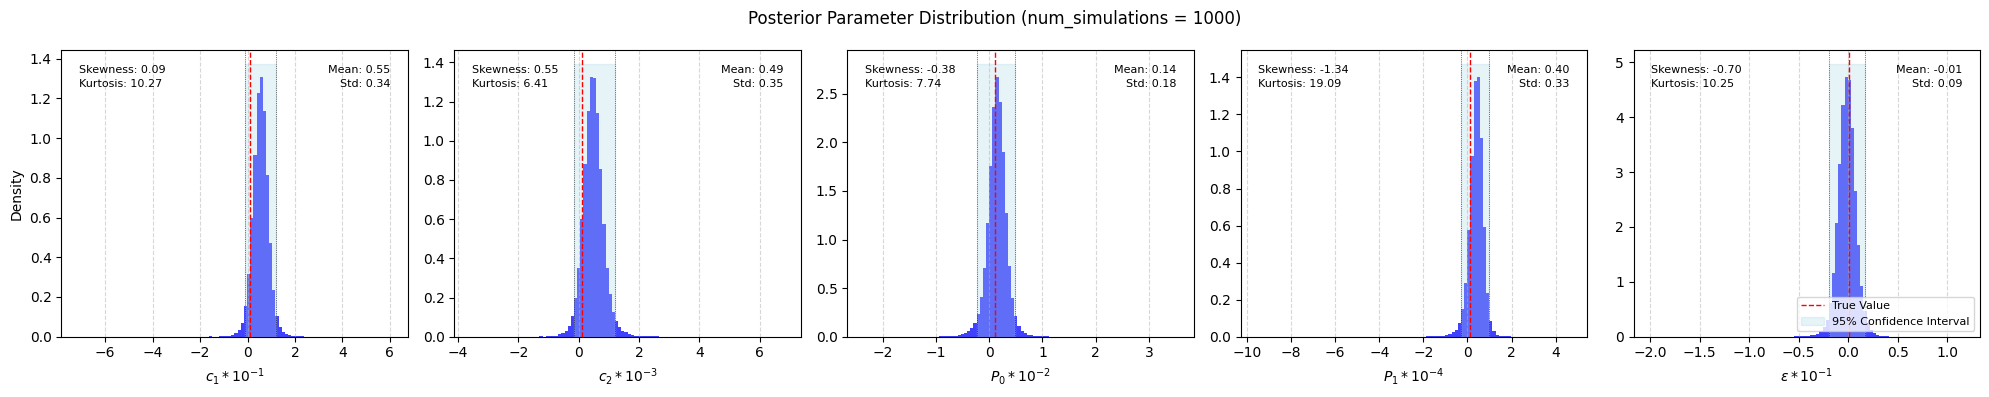

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

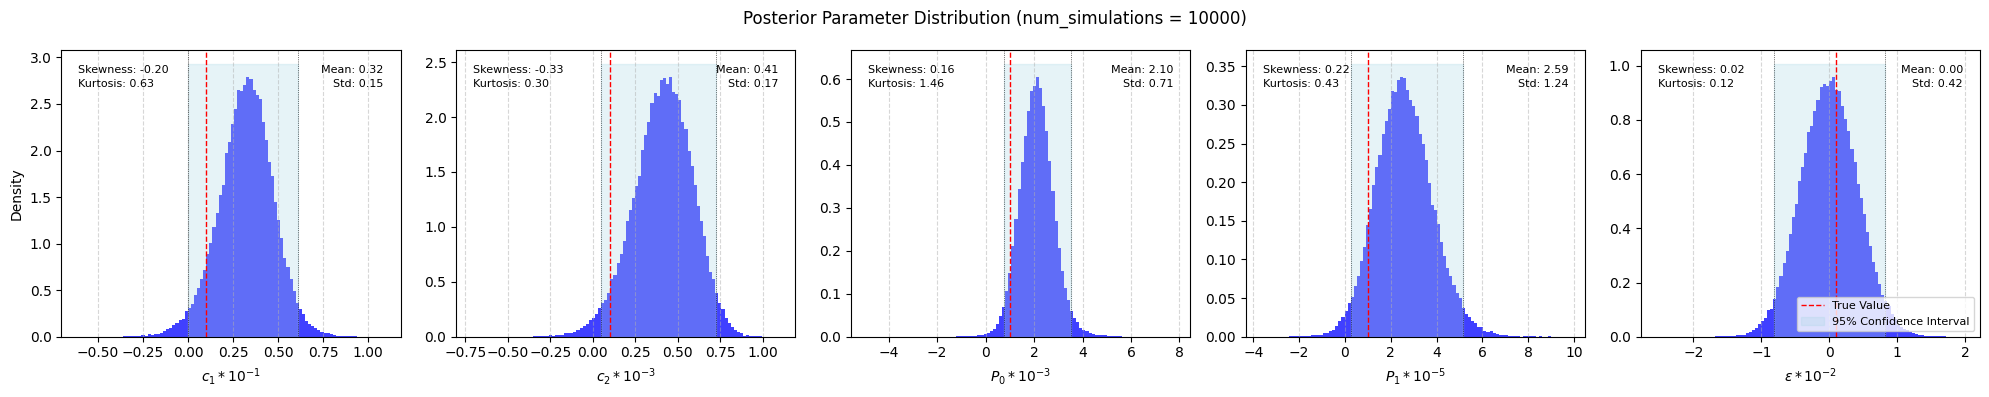

Drawing 100000 posterior samples:   0%|          | 0/100000 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

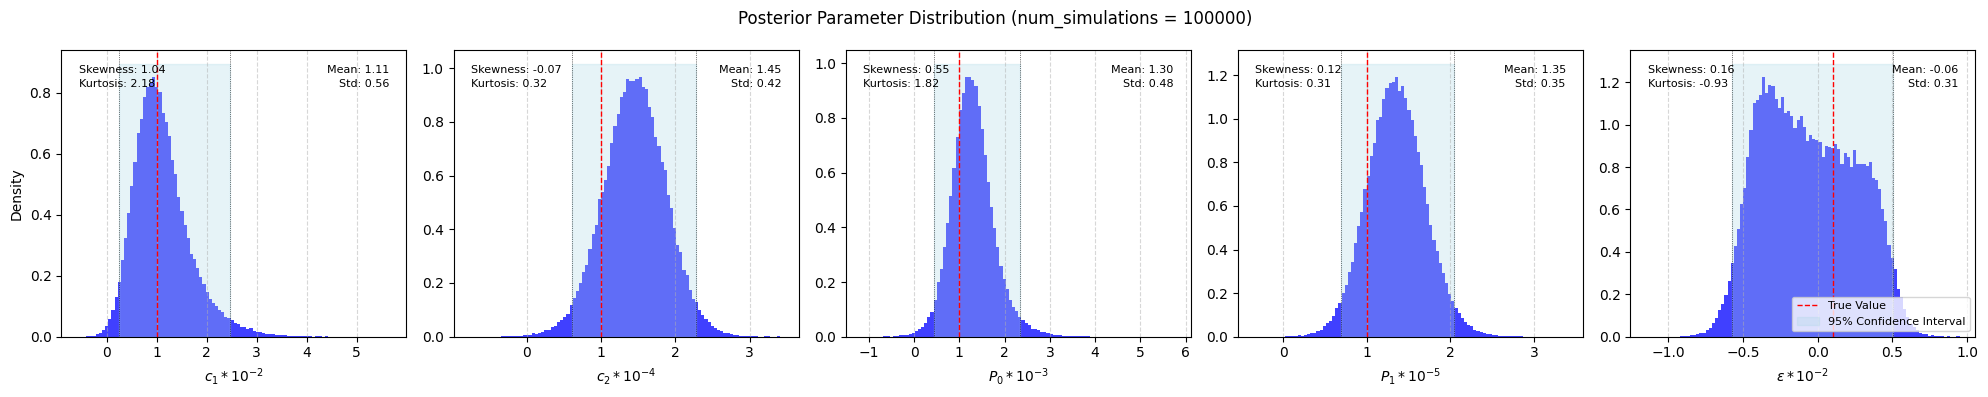

<Figure size 640x480 with 0 Axes>

In [8]:
distribution_analysis = DistributionAnalysis(true_parameters, output_path)

proposal_samples = proposal.sample((number_samples,))
prior_samples = prior.sample((number_samples,))

proposal_plot = distribution_analysis.plot_distribution_analytics(proposal_samples, 'Proposal', 'proposal')
prior_plot = distribution_analysis.plot_distribution_analytics(prior_samples, 'Prior', 'prior')

for (num_simulations, posterior) in posteriors:
    posterior_samples = posterior.sample((number_samples,))
    posterior_plot = distribution_analysis.plot_distribution_analytics(posterior_samples, f'Posterior (num_simulations = {num_simulations})', f'posterior_{num_simulations}')

In [ ]:
df_proposal = distribution_analysis.distribution_metrics(proposal_samples, 'proposal_statistics')
df_prior = distribution_analysis.distribution_metrics(prior_samples, 'prior_statistics')

for (num_simulations, posterior) in posteriors:
    posterior_samples = posterior.sample((number_samples,))
    df_posterior = distribution_analysis.distribution_metrics(posterior_samples, f'posterior_statistics_{num_simulations}')